# First Baseline 

In [16]:
import os
import time
import pickle
from datetime import datetime

import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy.stats as stats
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

## Load Dataset

In [17]:
data_dir = "../data"

crypto_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
asset_details = pd.read_csv(os.path.join(data_dir, "asset_details.csv"))

In [18]:
crypto_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [19]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [20]:
for idx, row in asset_details.sort_values(by="Asset_ID").iterrows():
    _df = crypto_df[crypto_df["Asset_ID"]==row["Asset_ID"]].set_index("timestamp")
    
    beg = _df.index[0].astype("datetime64[s]")
    end = _df.index[-1].astype("datetime64[s]")

    print(f"{row.Asset_Name:16} data gose from {beg} to {end}")

Binance Coin     data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Bitcoin          data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Bitcoin Cash     data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Cardano          data gose from 2018-04-17T09:11:00 to 2021-09-21T00:00:00
Dogecoin         data gose from 2019-04-12T14:34:00 to 2021-09-21T00:00:00
EOS.IO           data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Ethereum         data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Ethereum Classic data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
IOTA             data gose from 2018-05-09T08:07:00 to 2021-09-21T00:00:00
Litecoin         data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Maker            data gose from 2018-05-10T15:21:00 to 2021-09-21T00:00:00
Monero           data gose from 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Stellar          data gose from 2018-02-16T23:53:00 to 2021-09-21T00:00:00
TRON             data gos

## Preprocessing

In [21]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [22]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID=1 for Bitcoin
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp") # Asset_ID=6 for Ethereum
eth.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956200 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956200 non-null  int64  
 1   Count     1956200 non-null  float64
 2   Open      1956200 non-null  float64
 3   High      1956200 non-null  float64
 4   Low       1956200 non-null  float64
 5   Close     1956200 non-null  float64
 6   Volume    1956200 non-null  float64
 7   VWAP      1956200 non-null  float64
 8   Target    1955860 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.2 MB


In [23]:
eth.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      340
dtype: int64

In [24]:
# Reindex to fill nan missing data(timestamp).
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

In [25]:
def log_return(series, periods=1):
    """Calculate the difference after log transformation from the previous timestamp.
    """
    return np.log(series).diff(periods=periods)


def upper_shadow(asset):
    return asset.High - np.maximum(asset.Close, asset.Open)


def lower_shadow(asset):
    return np.minimum(asset.Close, asset.Open) - asset.Low

In [26]:
class CryptoFeature():
    
    def __init__(self, asset, start_date: str, end_date: str):
        self.asset = asset
        self.start_date = totimestamp(start_date)
        self.end_date = totimestamp(end_date)
    
    def get_features(self):
        log5_return = log_return(self.asset["VWAP"], periods=5)
        log1_return = log_return(self.asset["VWAP"], periods=1).abs()
        upper = upper_shadow(self.asset)
        lower = lower_shadow(self.asset)
        
        features =  pd.concat([
            self.asset["Open"],
            self.asset["High"],
            self.asset["Low"],
            self.asset["Close"],
            self.asset["Volume"],
            self.asset["VWAP"],
            log5_return,
            log1_return,
            upper,
            lower
        ], axis=1)
        
        features = features.loc[self.start_date:self.end_date].fillna(0)
        return features

    def get_target(self):
        return self.asset.loc[self.start_date:self.end_date, "Target"].fillna(0)

In [27]:
def dump_pickle(filename, data):
    with open(filename, "wb") as f:
        pickle.dump(data, f)        

In [35]:
params = dict(
    objective="regression",
    metric="rmse",
    learning_rate=5e-2,
    max_depth=-1,
    subsample_freq=3,
    subsample=0.9,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbosity=0,
    force_col_wise=True,
)

In [36]:
train_start_date, train_end_date = "01/04/2021", "30/04/2021"
test_start_date, test_end_date = "01/05/2021", "15/05/2021"

all_pred = []
all_true = []
assets = []

all_train_pred = []
all_train_true = []

results = pd.DataFrame(columns=["Asset_Name", "mse", "pearson_corr"])
for idx, row in asset_details.sort_values(by="Asset_ID").iterrows():
    print(f"\nTraining {row.Asset_Name} model")
    
    data = crypto_df[crypto_df["Asset_ID"]==row["Asset_ID"]].set_index("timestamp")
    data = data.reindex(range(data.index[0], data.index[-1]+60, 60),method='pad')
    
    train_feature = CryptoFeature(data, start_date=train_start_date, end_date=train_end_date)
    X_train = train_feature.get_features().to_numpy()
    y_train= train_feature.get_target().to_numpy()

    test_feature = CryptoFeature(data, start_date=test_start_date, end_date=test_end_date)
    X_test= test_feature.get_features().to_numpy()
    y_test = test_feature.get_target().to_numpy()

    train_set = lgb.Dataset(X_train, y_train)
    valid_set = lgb.Dataset(X_test, y_test)
    
    model = lgb.train(
        params, 
        train_set, 
        valid_sets=[train_set, valid_set],
        num_boost_round=100,
        callbacks=[
            lgb.log_evaluation(period=-1),
            lgb.early_stopping(stopping_rounds=10)
        ]
    )

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    all_pred.append(y_pred_test)
    all_true.append(y_test)
    assets.append([row["Asset_ID"] for _ in range(y_test.shape[0])])

    all_train_pred.append(y_pred_train)
    all_train_true.append(y_train)
    
    error = mean_squared_error(y_test, y_pred_test, squared=False)
    metric = pearsonr(y_test, y_pred_test)[0]
    
    results.loc[idx] = (row.Asset_Name, error, metric)
    
    
    # Save model and scaler.
#     os.makedirs(f"./{row.Asset_ID}/", exist_ok=True)
#     dump_pickle(f"./{row.Asset_ID}/model.pkl", model)


Training Binance Coin model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's rmse: 0.0060251	valid_1's rmse: 0.00397324

Training Bitcoin model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00198175	valid_1's rmse: 0.00235179

Training Bitcoin Cash model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00541975	valid_1's rmse: 0.00749674

Training Cardano model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00430473	valid_1's rmse: 0.00598014

Training Dogecoin model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.0166675	valid_1's rmse: 0.0156682

Training EOS.IO model
Training until validation scores don't improve for 10 rounds
Early stoppin

/home/rui/Documents/repositories/g-research-crypto-forecasting/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00729118	valid_1's rmse: 0.00727036

Training Monero model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00574133	valid_1's rmse: 0.00517024

Training Stellar model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.00625218	valid_1's rmse: 0.00710418

Training TRON model
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's rmse: 0.00778351	valid_1's rmse: 0.00521396


In [37]:
all_true = np.concatenate(all_true, axis=0)
all_pred = np.concatenate(all_pred, axis=0)
assets = np.concatenate(assets, axis=0)

all_train_pred = np.concatenate(all_train_pred, axis=0)
all_train_true = np.concatenate(all_train_true, axis=0)

In [38]:
error = mean_squared_error(all_true, all_pred, squared=False)
metric = pearsonr(all_true, all_pred)[0]

train_error = mean_squared_error(all_train_true, all_train_pred, squared=False)
train_metric = pearsonr(all_train_true, all_train_pred)[0]

print("train", train_error, train_metric)
print("test", error, metric)

train 0.007312972330904449 0.17580007088327437
test 0.0082663157685506 0.008453633280453897


In [39]:
results

,Asset_Name,mse,pearson_corr
1,Binance Coin,0.003973,0.049420
2,Bitcoin,0.002352,-0.023058
0,Bitcoin Cash,0.007497,0.020497
10,Cardano,0.005980,-0.028041
13,Dogecoin,0.015668,-0.028265
3,EOS.IO,0.010949,-0.016139
5,Ethereum,0.004157,0.031894
4,Ethereum Classic,0.013649,0.008019
11,IOTA,0.008953,0.049785
6,Litecoin,0.006083,0.033913


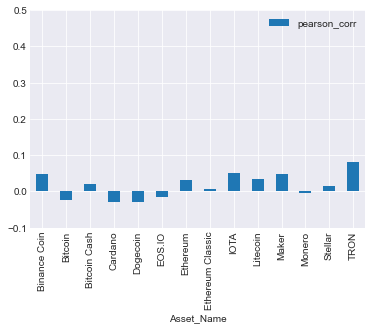

In [42]:
results.plot(kind="bar", x="Asset_Name", y="pearson_corr")
plt.ylim(-0.1, 0.5)
plt.show()

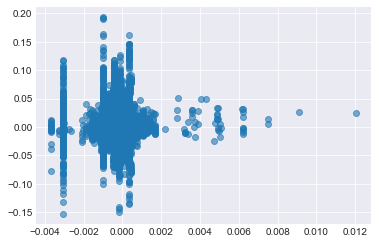

In [41]:
plt.scatter(
    all_pred, 
    all_true, 
#     c=assets, 
    alpha=0.6
)
plt.show()